In [16]:
%matplotlib inline 

#Import libraries 
import warnings, numpy as np, pandas as pan, matplotlib.pyplot as plt, seaborn as sns
from pandas_datareader import data
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error

warnings.filterwarnings('ignore')
np.random.seed(2018)

I always recommend that students and users import all of their libraries at the beginning of the file rather than importing them as they become necessary. Foremost, this is syntatically observed to be the case in most github repositories. Secondarily, this allows the code we write to be more legible

We will begin this lecture by first defining a function that will utilize the KNN algorithm for classification in which the toy example converges on a feasible solution 

The following example will be one in which the algorithm will not converge on a feasible solution and in contrast will be a regression use case.

Data Set Shape: 150,4

Correlation Coefficient Matrix:
           0         1         2         3
0  1.000000 -0.117570  0.871754  0.817941
1 -0.117570  1.000000 -0.428440 -0.366126
2  0.871754 -0.428440  1.000000  0.962865
3  0.817941 -0.366126  0.962865  1.000000

KNN Average Accuracy w/ 4 Neighbors: 0.95344

Confusion Matrix (Trial 1000):
 [[19  0  0]
 [ 0 14  0]
 [ 0  0 17]]

Accuracy Score Distribution Statistics:
                  0
count  1000.000000
mean      0.953440
std       0.027439
min       0.840000
25%       0.940000
50%       0.960000
75%       0.980000
max       1.000000


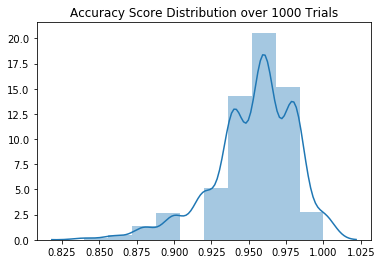

In [22]:
def model_iris_data(n_neighbors):
    '''
    This function loads the iris data from the sklearn datasets class, models this data set using KNN, 
    and then displays performance data on the algorithm (Classification)
    
    Arguments:
    
        n_neighbors - int - the number of neighbors to an observation KNN uses to output a discrete or continuous label
    
    :return: None
    '''

    raw_iris_data = datasets.load_iris()
    print('Data Set Shape: %s,%s'%(pan.DataFrame(raw_iris_data.data).shape))
    print('\nCorrelation Coefficient Matrix:\n %s'%(pan.DataFrame(raw_iris_data.data).corr()))

    x = pan.DataFrame(raw_iris_data.data[:, :4], columns=raw_iris_data.feature_names)
    y = pan.DataFrame(raw_iris_data.target)
    accuracy = []
    
    for i in range(1000):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.33)
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(train_X, train_y)
        predicted_labels = knn_model.predict(test_X)
        accuracy.append(accuracy_score(test_y, predicted_labels))
  
    print('\nKNN Average Accuracy w/ %s Neighbors: %s'%(n_neighbors, np.mean(accuracy)))
    print('\nConfusion Matrix (Trial 1000):\n %s'%(confusion_matrix(test_y, predicted_labels)))
    print('\nAccuracy Score Distribution Statistics:\n %s'%pan.DataFrame(accuracy).describe())

    sns.distplot(accuracy, bins=10).set_title('Accuracy Score Distribution over 1000 Trials')
    plt.show()
    
model_iris_data(n_neighbors=4)

Readers will observe that the above sample converged on a solution that yields an accuracy that is stable across many trials. This would be a solution that we should feel comfortable putting to further out of sample testing in the instance that we wanted to deploy this as a solution to this problem. 

Let's move forward to the next example, where we will try and predict the price of AAPL stock using KNN. This will not yield a good solution, however the focus of this section will be for us to try and hypothesize why this happened

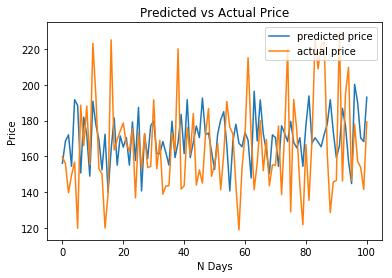


Summary Statistics on Average Mean Squared Error:                  0
count  1000.000000
mean    859.831430
std     102.440262
min     563.116544
25%     781.988475
50%     856.991876
75%     932.908513
max    1185.441376

Summary Statistics on AAPL Close Price:
             Close
count  101.000000
mean   165.425346
std     25.757958
min    119.040001
25%    146.279999
50%    161.470001
75%    176.240005
max    229.279999

Summary Statistics on AAPL Close Price Percentage Changes:
                 0
count  100.000000
mean     0.022328
std      0.211741
min     -0.412739
25%     -0.154390
50%      0.006500
75%      0.141574
max      0.617292

Summary Statistics on Prediction Difference:                 0
count  101.000000
mean    -4.532030
std     28.820833
min    -68.507504
25%    -20.780006
50%     -6.629997
75%     11.909996
max     63.549999


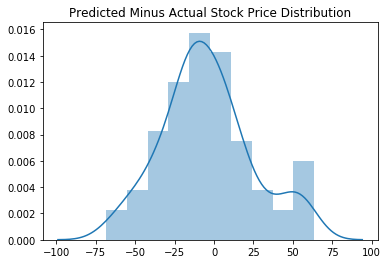

In [37]:
def model_stock_data(n_neighbors, ticker_symbol, start_date, end_date, data_source='yahoo'):
    '''
    This function loads the stock data from yahoo finance, models this data set using KNN, 
    and then displays performance data on the algorithm (Regression). Time series is sampled daily

    Arguments:

        n_neighbors - int - the number of neighbors to an observation KNN uses to output a discrete or continuous label
        ticker_symbol - str - the SPY ticker of the stock that is being modeled 
        start_date - str - initial sampling date of the time series (Format - YYYY-MM-DD)
        end_date - str - final sampling date of the time series (Format - YYYY-MM-DD)
        data_source - str - the data source from which the data is pulled (default: 'yahoo')
        
    '''
     
    stock_data = data.DataReader(name=ticker_symbol, 
                                 start=start_date, 
                                 end=end_date,
                                 data_source=data_source)
    
    x = stock_data.shift(1).dropna().reset_index(drop='index')
    y = stock_data.Close.shift(-1).dropna().reset_index(drop='index')
    _mean_squared_error = []
    
    for i in range(1000):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.20)
        test_y = test_y.reset_index(drop='index')
        knn_model = KNeighborsRegressor(n_neighbors=n_neighbors).fit(train_X, train_y)
        predicted_labels = knn_model.predict(test_X)
        _mean_squared_error.append(mean_squared_error(test_y, predicted_labels))
        
    prediction_difference = pan.DataFrame([test_y[i] - predicted_labels[i] for i in range(0, len(predicted_labels))])
    price_percentage_changes = [test_y[i]/float(test_y[i-1]) - 1 for i in range(1, len(test_y))]
    
    plt.plot(predicted_labels, label='predicted price')
    plt.plot(test_y, label='actual price')
    plt.title('Predicted vs Actual Price')
    plt.xlabel('N Days')
    plt.ylabel('Price')
    plt.legend(loc='upper right')
    plt.show()
        
    print('\nSummary Statistics on Average Mean Squared Error: %s'%pan.DataFrame(_mean_squared_error).describe())  
    print('\nSummary Statistics on AAPL Close Price:\n %s'%pan.DataFrame(test_y).describe())
    print('\nSummary Statistics on AAPL Close Price Percentage Changes:\n %s'%pan.DataFrame(price_percentage_changes).describe())
    print('\nSummary Statistics on Prediction Difference: %s'%prediction_difference.describe())
    sns.distplot(prediction_difference, bins=10).set_title('Predicted Minus Actual Stock Price Distribution')
    plt.show()

model_stock_data(n_neighbors=4,
                 ticker_symbol='AAPL', 
                 start_date='2017-01-01', 
                 end_date='2019-01-01',
                 data_source='yahoo')

As we can see, the presented solution is exceptionally inaccurate and does not merit further testing if we were to try and deploy this model. Not only is the mean squared error exceptionally high, we can visually see that it is significantly underfitting the data. Why might this be the case?